In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import v2
from tqdm import tqdm

## Utils

In [2]:
def rectangle(x):
    # Returns 1 where x is in [-0.5, 0.5], 0 elsewhere
    return ((x >= -0.5) & (x <= 0.5)).float()

class JumpReLU(torch.autograd.Function):
    """
    Custom autograd function for JumpReLU:
    Forward: x * 1{x > threshold}
    Backward: Learnable threshold with soft gradient approximation
    """

    @staticmethod
    def forward(ctx, x, threshold, bandwidth):
        # Save inputs for backward pass
        if not isinstance(bandwidth, torch.Tensor):
            bandwidth = torch.tensor(bandwidth, dtype=x.dtype, device=x.device)
        ctx.save_for_backward(x, threshold, bandwidth)
        return x * (x > threshold)

    @staticmethod
    def backward(ctx, grad_output):
        # Compute gradients w.r.t. x and threshold
        x, threshold, bandwidth = ctx.saved_tensors

        x_grad = (x > threshold).float() * grad_output
        threshold_grad = (
            -(threshold / bandwidth)
            * rectangle((x - threshold) / bandwidth)
            * grad_output
        ).sum(dim=0, keepdim=True)  # Sum over batch

        return x_grad, threshold_grad, None  # No gradient for fixed bandwidth

def jumprelu(x, threshold, bandwidth=1e-1):
    # Wrapper for JumpReLU
    return JumpReLU.apply(x, threshold, bandwidth)


class StepFunction(torch.autograd.Function):
    """
    Step function with differentiable surrogate gradient for threshold learning.
    Forward: binary step at threshold.
    Backward: gradient only for threshold (not input).
    """

    @staticmethod
    def forward(ctx, input, threshold, bandwidth):
        if not isinstance(threshold, torch.Tensor):
            threshold = torch.tensor(threshold, dtype=input.dtype, device=input.device)
        if not isinstance(bandwidth, torch.Tensor):
            bandwidth = torch.tensor(bandwidth, dtype=input.dtype, device=input.device)
        ctx.save_for_backward(input, threshold, bandwidth)
        return (input > threshold).type(input.dtype)

    @staticmethod
    def backward(ctx, grad_output):
        # Gradient only for threshold
        x, threshold, bandwidth = ctx.saved_tensors
        grad_input = 0.0 * grad_output  # no gradient w.r.t. input
        grad_threshold = (
            -(1.0 / bandwidth)
            * rectangle((x - threshold) / bandwidth)
            * grad_output
        ).sum(dim=0, keepdim=True)
        return grad_input, grad_threshold, None

def step(input, threshold, bandwidth=1e-1):
    # Wrapper for StepFunction
    return StepFunction.apply(input, threshold, bandwidth)


## SAEs Architectures

In [3]:
class MnistMP(torch.nn.Module):
    def __init__(self, params, device, D=None, b_pre=None):
        super(MnistMP, self).__init__()

        self.device = device
        self.p = params["p"]
        self.k = params["k"]
        self.dropout = params["dropout"]
        self.tied = params["tied"]

        if D is None:
            D = torch.randn((self.p, 28, 28), device=self.device)
        if b_pre is None:
            b_pre = torch.zeros((1, 28, 28), device=device)

        self.D = torch.nn.Parameter(D)

        if params["b_pre"]:
            self.b_pre = torch.nn.Parameter(b_pre)
        else:
            self.b_pre = torch.zeros((1, 28, 28), device=device)

        if params["normalize"]:
            self.normalize(params["normalize"])

        if self.tied:
            self.W = self.D
        else:
            self.W = torch.nn.Parameter(self.D.data.clone())

    def normalize(self, normalization):
        if normalization == "on":
            self.D.data = F.normalize(self.D.data, p=2, dim=[1, 2])
        elif normalization == "in":
            self.D.data = self.D.data / torch.maximum(
                torch.ones(1, device=self.device),
                torch.norm(self.D.data, p=2, dim=[1, 2], keepdim=True),
            )
        else:
            raise ValueError(
                'normalize should be "in"/"on" the hypersphere or set to False'
            )

    def encode(self, x):
        if self.dropout and self.training:
            keep_mask = torch.bernoulli(
                torch.full((self.p, 1, 1), 1 - self.dropout, device=self.device)
            )
            W = keep_mask * self.W
        else:
            W = self.W

        batch_size = x.shape[0]
        zhat = torch.zeros(batch_size, self.p, device=self.device)
        r = x.clone() - self.b_pre
        for _ in range(self.k):
            WTr = (W * r).sum(axis=[-1, -2])
            values, indices = torch.max(torch.relu(WTr), dim=1, keepdim=True)
            zhat_ = torch.zeros_like(zhat).scatter_(1, indices, values)
            zhat += zhat_
            r = r - torch.einsum("ijk,li->ljk", self.D, zhat_).unsqueeze(1)
        return zhat

    def decode(self, z):
        return (
            torch.einsum(
                "ijk,li->ljk",
                self.D,
                z,
            ).unsqueeze(1)
            + self.b_pre
        )

    def forward(self, x):
        zhat = self.encode(x)
        xhat = self.decode(zhat)
        return xhat, zhat

In [4]:
class MnistReLU(torch.nn.Module):
    def __init__(self, params, device, D=None, b_pre=None):
        super(MnistReLU, self).__init__()

        self.device = device
        self.p = params["p"]
        self.dropout = params["dropout"]
        self.tied = params["tied"]

        if D is None:
            D = torch.randn((self.p, 28, 28), device=device)
        if b_pre is None:
            b_pre = torch.zeros((1, 28, 28), device=device)

        self.D = torch.nn.Parameter(D)

        if params["b_pre"]:
            self.b_pre = torch.nn.Parameter(b_pre)
        else:
            self.b_pre = torch.zeros((1, 28, 28), device=device)

        if params["normalize"]:
            self.normalize(params["normalize"])

        if self.tied:
            self.W = self.D
        else:
            self.W = torch.nn.Parameter(self.D.data.clone())

        self.b_enc = torch.nn.Parameter(torch.zeros(self.p, device=device))

    def normalize(self, normalization):
        if normalization == "on":
            self.D.data = F.normalize(self.D.data, p=2, dim=[1, 2])
        elif normalization == "in":
            self.D.data = self.D.data / torch.maximum(
                torch.ones(1, device=self.device),
                torch.norm(self.D.data, p=2, dim=[1, 2], keepdim=True),
            )
        else:
            raise ValueError(
                'normalize should be "in"/"on" the hypersphere or set to False'
            )

    def encode(self, x):
        if self.dropout and self.training:
            keep_mask = torch.bernoulli(
                torch.full((self.p, 1, 1), 1 - self.dropout, device=self.device)
            )
            W = keep_mask * self.W
            b_enc = keep_mask.squeeze() * self.b_enc

        else:
            W = self.W
            b_enc = self.b_enc

        WTr_b = (W * (x - self.b_pre)).sum(axis=[-1, -2]) + b_enc
        zhat = torch.relu(WTr_b)
        return zhat

    def decode(self, z):
        return (
            torch.einsum(
                "ijk,li->ljk",
                self.D,
                z,
            ).unsqueeze(1)
            + self.b_pre
        )

    def forward(self, x):
        zhat = self.encode(x)
        xhat = self.decode(zhat)
        return xhat, zhat

In [5]:
class MnistJumpReLU(torch.nn.Module):
    def __init__(self, params, device, D=None, b_pre=None):
        super(MnistJumpReLU, self).__init__()

        self.device = device
        self.p = params["p"]
        self.dropout = params["dropout"]
        self.tied = params["tied"]

        if D is None:
            D = torch.randn((self.p, 28, 28), device=device)
        if b_pre is None:
            b_pre = torch.zeros((1, 28, 28), device=device)

        self.D = torch.nn.Parameter(D)

        if params["b_pre"]:
            self.b_pre = torch.nn.Parameter(b_pre)
        else:
            self.b_pre = torch.zeros((1, 28, 28), device=device)

        if params["normalize"]:
            self.normalize(params["normalize"])

        if self.tied:
            self.W = self.D
        else:
            self.W = torch.nn.Parameter(self.D.data.clone())

        self.b_enc = torch.nn.Parameter(torch.zeros(self.p, device=device))
        self.log_thresholds = torch.nn.Parameter(
            torch.log(0.1 * torch.ones(self.p, device=device))
        )

    def normalize(self, normalization):
        if normalization == "on":
            self.D.data = F.normalize(self.D.data, p=2, dim=[1, 2])
        elif normalization == "in":
            self.D.data = self.D.data / torch.maximum(
                torch.ones(1, device=self.device),
                torch.norm(self.D.data, p=2, dim=[1, 2], keepdim=True),
            )
        else:
            raise ValueError(
                'normalize should be "in"/"on" the hypersphere or set to False'
            )

    def encode(self, x):
        if self.dropout and self.training:
            keep_mask = torch.bernoulli(
                torch.full((self.p, 1, 1), 1 - self.dropout, device=self.device)
            )
            W = keep_mask * self.W
            b_enc = keep_mask.squeeze() * self.b_enc

        else:
            W = self.W
            b_enc = self.b_enc

        WTr_b = (W * (x - self.b_pre)).sum(axis=[-1, -2]) + b_enc

        zhat = jumprelu(
            torch.relu(WTr_b),
            threshold=torch.exp(self.log_thresholds),
        )
        return zhat

    def decode(self, z):
        return (
            torch.einsum(
                "ijk,li->ljk",
                self.D,
                z,
            ).unsqueeze(1)
            + self.b_pre
        )

    def forward(self, x):
        zhat = self.encode(x)
        xhat = self.decode(zhat)
        return xhat, zhat

In [6]:
class MnistTopK(torch.nn.Module):
    def __init__(self, params, device, D=None, b_pre=None):
        super(MnistTopK, self).__init__()

        self.device = device
        self.p = params["p"]
        self.k = params["k"]
        self.dropout = params["dropout"]
        self.tied = params["tied"]

        if D is None:
            D = torch.randn((self.p, 28, 28), device=self.device)
        if b_pre is None:
            b_pre = torch.zeros((1, 28, 28), device=device)

        self.D = torch.nn.Parameter(D)

        if params["b_pre"]:
            self.b_pre = torch.nn.Parameter(b_pre)
        else:
            self.b_pre = torch.zeros((1, 28, 28), device=device)

        if params["normalize"]:
            self.normalize(params["normalize"])

        if self.tied:
            self.W = self.D
        else:
            self.W = torch.nn.Parameter(self.D.data.clone())

        self.b_enc = torch.nn.Parameter(torch.zeros(self.p, device=device))

    def normalize(self, normalization):
        if normalization == "on":
            self.D.data = F.normalize(self.D.data, p=2, dim=[1, 2])
        elif normalization == "in":
            self.D.data = self.D.data / torch.maximum(
                torch.ones(1, device=self.device),
                torch.norm(self.D.data, p=2, dim=[1, 2], keepdim=True),
            )
        else:
            raise ValueError(
                'normalize should be "in"/"on" the hypersphere or set to False'
            )

    def encode(self, x):
        if self.dropout and self.training:
            keep_mask = torch.bernoulli(
                torch.full((self.p, 1, 1), 1 - self.dropout, device=self.device)
            )

            W = keep_mask * self.W
            b_enc = keep_mask.squeeze() * self.b_enc

        else:
            W = self.W
            b_enc = self.b_enc

        batch_size = x.shape[0]
        WTr_b = (W * (x - self.b_pre)).sum(axis=[-1, -2]) + b_enc

        values, indices = torch.topk(
            torch.relu(WTr_b),
            k=self.k,
            dim=1,
        )
        zhat = torch.zeros(batch_size, self.p, device=self.device).scatter_(
            1, indices, values
        )
        return zhat

    def decode(self, z):
        return (
            torch.einsum(
                "ijk,li->ljk",
                self.D,
                z,
            ).unsqueeze(1)
            + self.b_pre
        )

    def forward(self, x):
        zhat = self.encode(x)
        xhat = self.decode(zhat)
        return xhat, zhat

In [7]:
class MnistBatchTopK(torch.nn.Module):
    def __init__(self, params, device, D=None, b_pre=None):
        super(MnistBatchTopK, self).__init__()

        self.device = device
        self.p = params["p"]
        self.k = params["k"]
        self.dropout = params["dropout"]
        self.tied = params["tied"]
        self.register_buffer(
            "threshold", torch.tensor(float("nan"), device=self.device)
        )
        self.threshold_momentum = 0.9

        if D is None:
            D = torch.randn((self.p, 28, 28), device=self.device)
        if b_pre is None:
            b_pre = torch.zeros((1, 28, 28), device=device)

        self.D = torch.nn.Parameter(D)

        if params["b_pre"]:
            self.b_pre = torch.nn.Parameter(b_pre)
        else:
            self.b_pre = torch.zeros((1, 28, 28), device=device)

        if params["normalize"]:
            self.normalize(params["normalize"])

        if self.tied:
            self.W = self.D
        else:
            self.W = torch.nn.Parameter(self.D.data.clone())

        self.b_enc = torch.nn.Parameter(torch.zeros(self.p, device=device))

    def normalize(self, normalization):
        if normalization == "on":
            self.D.data = F.normalize(self.D.data, p=2, dim=[1, 2])
        elif normalization == "in":
            self.D.data = self.D.data / torch.maximum(
                torch.ones(1, device=self.device),
                torch.norm(self.D.data, p=2, dim=[1, 2], keepdim=True),
            )
        else:
            raise ValueError(
                'normalize should be "in"/"on" the hypersphere or set to False'
            )

    def encode(self, x):
        if self.dropout and self.training:
            keep_mask = torch.bernoulli(
                torch.full((self.p, 1, 1), 1 - self.dropout, device=self.device)
            )

            W = keep_mask * self.W
            b_enc = keep_mask.squeeze() * self.b_enc

        else:
            W = self.W
            b_enc = self.b_enc

        batch_size = x.shape[0]
        WTr_b = (W * (x - self.b_pre)).sum(axis=[-1, -2]) + b_enc
        if self.training:
            values, indices = torch.topk(
                torch.relu(WTr_b.flatten()),
                k=self.k * batch_size,
                dim=0,
            )
            zhat = (
                torch.zeros(batch_size * self.p, device=self.device)
                .scatter(0, indices, values)
                .reshape(batch_size, self.p)
            )
            if torch.isnan(self.threshold):
                self.threshold.data = values[-1].detach()
            else:
                self.threshold.data = (
                    self.threshold_momentum * self.threshold
                    + (1 - self.threshold_momentum) * values[-1].detach()
                )
        else:
            mask = (WTr_b >= self.threshold).float()
            zhat = WTr_b * mask
        return zhat

    def decode(self, z):
        return (
            torch.einsum(
                "ijk,li->ljk",
                self.D,
                z,
            ).unsqueeze(1)
            + self.b_pre
        )

    def forward(self, x):
        zhat = self.encode(x)
        xhat = self.decode(zhat)
        return xhat, zhat

## Train

### Config

In [27]:
config = {
    "device": "cuda",  # Device to use for training (e.g., "cuda" or "cpu")
    "num_epochs": 50,  # Number of training epochs
    "network": "ReLU",  # SAE class to use
    "lr": 1.0e-3,  # Learning rate
}

config["net_params"] = {  # Parameters passed to the model
    "p": 1000,  # Dictionary size (number of atoms)
    "k": 10,  # Sparsity level (number of active atoms)
    "normalize": "on",  # Dictionary normalization method ("on" = unit norm)
    "dropout": (
        0.75 if config["network"] == "MP" else 0
    ),  # Dropout probability during training
    "tied": False,  # Whether encoder and decoder share weights
    "b_pre": True,  # Learnable input bias
}

config["dataloader"] = {  # DataLoader settings for training
    "shuffle": True,  # Shuffle dataset each epoch
    "batch_size": 50,  # Training batch size
    "num_workers": 0,  # Number of parallel data loading workers
}

In [28]:
network_classes = {
    "MP": MnistMP,
    "TopK": MnistTopK,
    "ReLU": MnistReLU,
    "JumpReLU": MnistJumpReLU,
    "BatchTopK": MnistBatchTopK,
}

regularization_penalty = {
    "MP": 0,
    "TopK": 0.1,
    "BatchTopK": 0.1,
    "ReLU": 0.1,
    "JumpReLU": 10,
}

### SAE

In [31]:
net = network_classes[config["network"]](
    config["net_params"],
    device=config["device"],
    b_pre = torch.load("b_pre.pt").to(config["device"]),  # Pre-bias initialized as the geometric mean of the training data
)

### Data

In [29]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
dataset = MNIST("data", train=True, transform=transform, download=True)
train_dataset = torch.utils.data.Subset(dataset, range(50000))
train_loader = torch.utils.data.DataLoader(train_dataset, **config["dataloader"])

### Training 

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
reg_penalty = regularization_penalty[config["network"]]

for epoch in tqdm(range(config["num_epochs"])):
    net.train()

    if epoch > 0:
        net.dropout = 0

    for idx, (x, _) in tqdm(enumerate(train_loader), disable=True):
        optimizer.zero_grad()

        x = x.to(config["device"])

        zhat = net.encode(x)
        xhat = net.decode(zhat)

        loss = torch.sum((x - xhat) ** 2, dim=[-1, -2]).mean()

        # ReLU L1 loss
        if config["network"] == "MnistReLU":
            sparsity = torch.sum(zhat != 0, dim=1).float().mean()
            if sparsity > config["net_params"]["k"]:
                loss += reg_penalty * zhat.abs().sum(dim=1).mean()
            if sparsity > 1.5 * config["net_params"]["k"]:
                reg_penalty *= 1.001

        # JumpReLU L0 target loss
        if config["network"] == "MnistJumpReLU":
            loss += (
                reg_penalty
                * (
                    (
                        step(
                            (net.W * (x - net.b_pre)).sum(axis=[-1, -2]) + net.b_enc,
                            threshold=torch.exp(net.log_thresholds),
                        ).sum(dim=1)
                        / config["net_params"]["k"]
                    )
                    - 1
                )
                ** 2
            ).mean()

        # TopK / BatchTopK auxiliary loss
        if config["network"] == "MnistTopK" or config["network"] == "MnistBatchTopK":
            projection = (net.W * (x - net.b_pre)).sum(axis=[-1, -2]) + net.b_enc
            unused_codes = torch.relu(projection) - zhat
            auxiliary_topk = torch.topk(unused_codes, k=net.p // 2, dim=1)
            top_unused_codes = torch.zeros_like(zhat).scatter(
                1, auxiliary_topk.indices, auxiliary_topk.values
            )

            residual_hat = net.decode(top_unused_codes)
            auxilary_mse = torch.sum(
                (x - (xhat + residual_hat)) ** 2, dim=[-1, -2]
            ).mean()
            loss += reg_penalty * auxilary_mse

        loss.backward()
        optimizer.step()
        if config["net_params"]["normalize"]:
            net.normalize(config["net_params"]["normalize"])

100%|██████████| 2/2 [00:39<00:00, 19.79s/it]


In [19]:
torch.save(net.state_dict(), f'{config["network"]}_p{net.p}_k{config["net_params"]["k"]}.pt')

## Evaluation 

### Load model

In [32]:
# Remove the SAEs_trained/ folder if you want to use the newly trained network instead of loading a saved one
net.load_state_dict(torch.load(f'SAEs_trained/{config["network"]}_p{net.p}_k{config["net_params"]["k"]}.pt', weights_only=True))

<All keys matched successfully>

In [33]:
net.eval()

MnistReLU()

### Input

In [34]:
dataset = MNIST("data", train=True, transform=transform)
val_dataset = torch.utils.data.Subset(dataset, range(50000,len(dataset)))

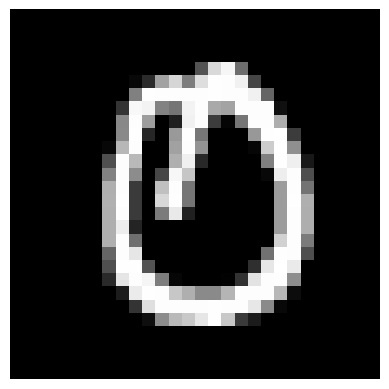

In [35]:
index = 18
x_gt, _ = val_dataset[index] 

plt.imshow(x_gt[0], cmap="gray")
plt.axis("off");

In [36]:
with torch.no_grad():
    x = x_gt.to(config["device"]).unsqueeze(0)
    z_hat = net.encode(x)
    x_hat = net.decode(z_hat)


### Reconstruction

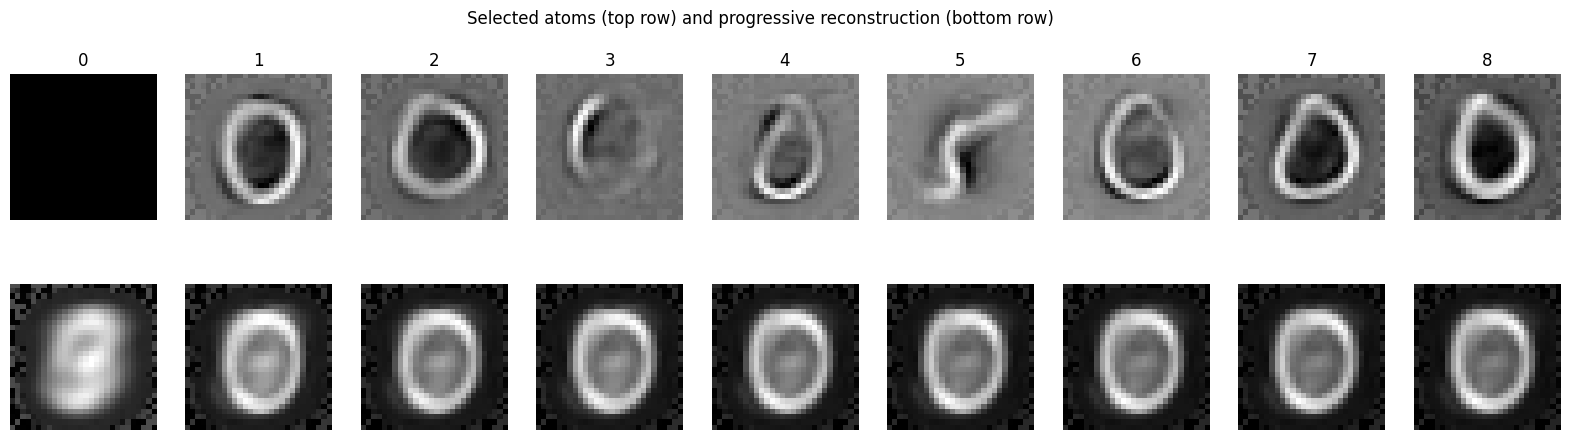

In [37]:
z_hat_L0 = int((z_hat != 0).sum())
atoms_indices_sorted = torch.argsort(z_hat.squeeze(0), descending=True)[:z_hat_L0]
atoms = net.D[atoms_indices_sorted].detach().cpu()

fig, axes = plt.subplots(2, z_hat_L0 + 1, figsize=(20,5))
fig.suptitle("Selected atoms (top row) and progressive reconstruction (bottom row)")
for i in range(len(atoms_indices_sorted)+1):
    if i == 0:
        axes[0, i].imshow(torch.zeros(28, 28), cmap="gray")
        axes[0, i].axis("off")
    else:
        axes[0, i].imshow(atoms[i-1], cmap="gray")
        axes[0, i].axis("off")
    axes[0, i].set_title(i)

    if i == 0:
        axes[1, i].imshow(net.b_pre.detach().cpu()[0], cmap="gray")
        axes[1, i].axis("off")
    else:
        z_ = torch.zeros_like(z_hat)
        z_[:, atoms_indices_sorted[:i]] = z_hat[:, atoms_indices_sorted[:i]]
        axes[1, i].imshow(net.decode(z_)[0,0].detach().cpu(), cmap="gray")
        axes[1, i].axis("off")